In [37]:
from transformer_models import *
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import json
import sys
sys.path.append('/Users/philvanlane/Documents/lc_ae')
from data_prep import *

In [40]:
len(star_dataset)

181523

In [47]:
len(subset_dataset[0][0][0])

2

In [49]:
### Subset of star data

# Load the full dataset

# # Extract data for the subset
# flux = star_dataset.flux[indices]
# t = star_dataset.t[indices]
# flux_err = star_dataset.flux_err[indices] if star_dataset.flux_err is not None else None

# # Create a new FluxDataset with the subset
# from transformer_models import FluxDataset
# subset_dataset = FluxDataset(flux, t, flux_err)

# # Save the subset
# torch.save(subset_dataset, 'star_dataset_subset.pt')

In [2]:
lc_data_folder = '/Users/philvanlane/Documents/proj_lc_ages/data/star_data/'
proj_folder = '/Users/philvanlane/Documents/lc_ae/'
trans_folder = proj_folder + 'transformer/'
artifact_folder = trans_folder + 'model_artifacts/'

star_files = os.listdir(lc_data_folder)
tics = [f.split("_")[-1].split(".")[0] for f in star_files]

In [3]:
def getStarData(tic_id):
    # Load the star data for the given TIC ID
    with open(f"{lc_data_folder}/pk_star_day_lc_cf_norm_enc_{tic_id}.pickle", "rb") as f:
        star_data = pickle.load(f)
    return star_data


In [4]:
def chi_squared_loss(pred, target, uncertainty):
    """
    pred, target, uncertainty: (batch, seq_len, 1)
    """
    # Avoid division by zero
    uncertainty = torch.clamp(uncertainty, min=1e-8)
    
    chi2 = ((pred - target) ** 2) / (uncertainty ** 2)
    return chi2.mean()

#### All stars data

In [ ]:
# star_flux = []
# star_flux_err = []
# star_t = []
# for t in tics:
#     star_dict = getStarData(t)
#     for k in star_dict.keys():
#         flux = star_dict[k]['flux_d_padded']
#         flux_err = star_dict[k]['flux_err_d_padded']
#         t = star_dict[k]['time_d_padded']

#         # Handle NaNs
#         flux[np.isnan(flux)] = 0
#         flux_err[np.isnan(flux_err)] = np.nanmedian(flux_err)
#         flux_err[np.isnan(flux)] = 5 * np.nanmedian(flux_err)

#         # Append sequences
#         star_flux.append(flux)
#         star_flux_err.append(flux_err)
#         star_t.append(t)
# star_flux = np.array(star_flux)
# star_flux_err = np.array(star_flux_err)
# star_t = np.array(star_t)
# star_dataset = FluxDataset(star_flux, star_t, star_flux_err)
# torch.save(star_dataset, trans_folder + 'star_dataset.pt')

In [50]:
### Replacing infinity values in error

# # Choose the replacement value, e.g., the median of non-inf values
# replacement_value = torch.nanmedian(star_dataset.flux_err[~torch.isinf(star_dataset.flux_err)])

# # Replace inf values with the chosen value
# star_dataset.flux_err[torch.isinf(star_dataset.flux_err)] = replacement_value

star_dataset = torch.load(trans_folder + 'star_dataset_subset.pt',weights_only=False)

#### Sample star data

In [ ]:
# star_dict = getStarData(427580133)
# star_flux = []
# star_flux_err = []
# for k in star_dict.keys():
#     star_flux.append(star_dict[k]['flux_d_padded'])
#     star_flux_err.append(star_dict[k]['flux_err_d_padded'])
#     # if np.isnan(star_flux).sum() > 0:
#     #     print(k)
#     #     print("NaN values found in flux!")
#     # if np.isnan(star_flux_err).sum() > 0:
#     #     print(k)
#     #     print("NaN values found in flux error!")
# star_flux = np.array(star_flux)
# star_flux_err = np.array(star_flux_err)
# star_dataset = FluxDataset(star_flux, star_flux_err)


### Train using subset of stars for performance

In [7]:
def train_lc_transformer(dataset,train_config):

    # Test split
    test_size = int(len(dataset) * train_config['test_ratio'])
    train_val_size = len(dataset) - test_size
    test_dataset, train_val_dataset = torch.utils.data.random_split(dataset, [test_size, train_val_size])

    # Train val split
    train_size = int(train_val_size * train_config['train_ratio'])
    val_size = train_val_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

    # Model
    model = TimeSeriesTransformer(min_period=0.00278,max_period=1640,embed_dim=32, ff_dim=64, num_layers=2)
    optimizer = torch.optim.AdamW(model.parameters(),lr=train_config['learning_rate'],weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    # criterion = nn.MSELoss()

    # Set up training
    epochs = train_config['epochs']
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')

    # Training
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training
        for xb, tb, yb, yb_err in train_loader:

            yb_err = torch.clamp(yb_err, min=1e-2)

            # print("xb:", torch.isnan(xb).sum(), xb.min().item(), xb.max().item())
            # print("yb:", torch.isnan(yb).sum(), yb.min().item(), yb.max().item())
            # print("yb_err:", torch.isnan(yb_err).sum(), yb_err.min().item(), yb_err.max().item())
            # print("pred:", torch.isnan(pred).sum(), pred.min().item(), pred.max().item())

            xb_masked, mask = block_predefined_mask_lc(xb,
                                block_size=train_config['mask_block_size'],
                                mask_ratio=train_config['mask_ratio'])
            
            optimizer.zero_grad()
            pred = model(xb_masked,tb)
            loss = chi_squared_loss(pred, yb, yb_err)     
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb,tb,yb,yb_err in val_loader:
                pred = model(xb,tb)
                loss = chi_squared_loss(pred, yb, yb_err)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Stats
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        if (epoch + 1) % 5 == 0 or epoch == epochs - 1 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.2e}")

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"Training completed!")
    print(f"Final validation loss: {val_losses[-1]:.6f}")

    return model, train_losses, val_losses, learning_rates


### Training using learnable masked tokens

In [31]:
def combined_chi_squared_loss(pred, target, uncertainty, mask, alpha=0.8):
    # Assume pred is [batch, seq_len, 1] (only flux)
    pred = pred.reshape(-1, 1)
    target = target.reshape(-1, 1)
    uncertainty = uncertainty.reshape(-1, 1)
    mask = mask.reshape(-1)
    chi2 = ((pred - target) ** 2) / (torch.clamp(uncertainty, min=1e-8) ** 2)
    # Masked loss
    masked_loss = chi2[mask].mean()
    # Unmasked loss
    unmasked_loss = chi2[~mask].mean()
    # Weighted sum
    return alpha * masked_loss + (1 - alpha) * unmasked_loss

In [12]:
def masked_chi_squared_loss(pred, target, uncertainty, mask):
    # Flatten batch and sequence dimensions
    pred = pred.reshape(-1, 1)
    target = target.reshape(-1, 1)
    uncertainty = uncertainty.reshape(-1, 1)
    mask = mask.reshape(-1)
    # Compute chi-squared only on masked positions
    chi2 = ((pred - target) ** 2) / (torch.clamp(uncertainty, min=1e-8) ** 2)
    masked_chi2 = chi2[mask]
    return masked_chi2.mean()

In [51]:
def train_lc_transformer_v2(dataset,train_config):

    # Test split
    test_size = int(len(dataset) * train_config['test_ratio'])
    train_val_size = len(dataset) - test_size
    test_dataset, train_val_dataset = torch.utils.data.random_split(dataset, [test_size, train_val_size])

    # Train val split
    train_size = int(train_val_size * train_config['train_ratio'])
    val_size = train_val_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

    # Model
    model = MaskedTimeSeriesTransformer(
        input_dim=2,  # e.g., 3 features per timestep
        d_model=train_config['num_model_dimensions'],
        nhead=train_config['num_model_heads'],
        num_layers=train_config['num_model_layers']
        )
    optimizer = torch.optim.AdamW(model.parameters(),lr=train_config['learning_rate'],weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    # criterion = nn.MSELoss()

    # Set up training
    epochs = train_config['epochs']
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')

    # Training
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training
        for xb, tb, yb, yb_err in train_loader:

            yb_err = torch.clamp(yb_err, min=1e-2)

            # print("xb:", torch.isnan(xb).sum(), xb.min().item(), xb.max().item())
            # print("yb:", torch.isnan(yb).sum(), yb.min().item(), yb.max().item())
            # print("yb_err:", torch.isnan(yb_err).sum(), yb_err.min().item(), yb_err.max().item())
            # print("pred:", torch.isnan(pred).sum(), pred.min().item(), pred.max().item())

            xb_masked, mask = block_predefined_mask_lc(xb,
                                block_size=train_config['mask_block_size'],
                                mask_ratio=train_config['mask_ratio'])

            x_original = xb.clone()
            predictions, mask_used = model(xb_masked, tb.squeeze(-1), mask)
            
            optimizer.zero_grad()
            pred, _ = model(xb_masked, tb.squeeze(-1), mask)
            loss = combined_chi_squared_loss(pred, yb, yb_err, mask)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb,tb,yb,yb_err in val_loader:
                pred, _ = model(xb,tb.squeeze(-1))
                loss = chi_squared_loss(pred, yb, yb_err)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Stats
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        if (epoch + 1) % 1 == 0 or epoch == epochs - 1 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.2e}")

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"Training completed!")
    print(f"Final validation loss: {val_losses[-1]:.6f}")

    return model, train_losses, val_losses, learning_rates


### Config

In [54]:
version = 'v08'
train_config = {
    'num_model_heads': 2,
    'num_model_layers': 3,
    'num_model_dimensions': 128,
    'test_ratio': 0.8,
    'train_ratio': 0.8,
    'batch_size': 64,
    'epochs': 10,
    'mask_block_size': 10,
    'mask_ratio': 0.1,
    'learning_rate': 1e-4,
    'weight_decay': 1e-2,
    'notes': 'Testing learnable mask token and only training on masked loss.'
}

Train size: 1452, Val size: 364, Test size: 7260
Epoch   1: Train Loss = 39.926500, Val Loss = 5.074142, LR = 1.00e-04
Epoch   1: Train Loss = 39.926500, Val Loss = 5.074142, LR = 1.00e-04
Epoch   2: Train Loss = 33.338112, Val Loss = 1.124818, LR = 1.00e-04
Epoch   2: Train Loss = 33.338112, Val Loss = 1.124818, LR = 1.00e-04
Epoch   3: Train Loss = 32.928113, Val Loss = 0.607896, LR = 1.00e-04
Epoch   3: Train Loss = 32.928113, Val Loss = 0.607896, LR = 1.00e-04
Epoch   4: Train Loss = 28.053877, Val Loss = 0.935122, LR = 1.00e-04
Epoch   4: Train Loss = 28.053877, Val Loss = 0.935122, LR = 1.00e-04
Epoch   5: Train Loss = 27.360927, Val Loss = 0.847245, LR = 1.00e-04
Epoch   5: Train Loss = 27.360927, Val Loss = 0.847245, LR = 1.00e-04
Epoch   6: Train Loss = 28.847176, Val Loss = 0.473368, LR = 1.00e-04
Epoch   6: Train Loss = 28.847176, Val Loss = 0.473368, LR = 1.00e-04
Epoch   7: Train Loss = 37.859220, Val Loss = 0.678240, LR = 1.00e-04
Epoch   7: Train Loss = 37.859220, Val Lo

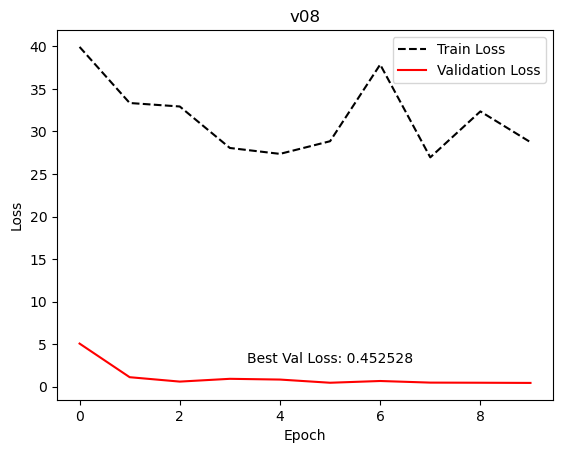

In [55]:
model, train_losses, val_losses, learning_rates = train_lc_transformer_v2(star_dataset, train_config)
save_folder = artifact_folder

# Save parameters
torch.save(model.state_dict(), save_folder + version + "_trans_ae.pt")
np.save(save_folder + version + "_training_data.npy", np.array([train_losses,val_losses,learning_rates]))

# Save configs
log_data = {
    'version': version,
    'train_config': train_config,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'num_parameters': sum(p.numel() for p in model.parameters()),
    # 'compression_ratio': model.get_compression_ratio()
}

with open(f"{save_folder}{version}_config_log.json", "w") as f:
    json.dump(log_data, f, indent=2)


# Plot
plt.plot(train_losses, label='Train Loss',color='black',linestyle='dashed')
plt.plot(val_losses, label='Validation Loss',color='red')
best_val_loss = min(val_losses)
plt.text(train_config.get('epochs')/2, (max(val_losses) + best_val_loss)/2,
         f'Best Val Loss: {best_val_loss:.6f}', fontsize=10, ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(version)
plt.legend()
plt.savefig(save_folder + version + "_losses.png")
plt.show()

### Reconstruction (no mask)

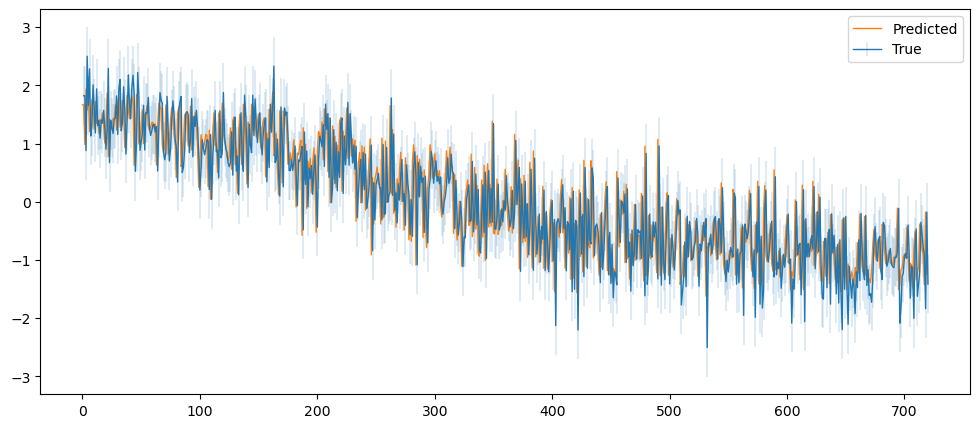

In [58]:
rand_idx = np.random.randint(0, len(star_dataset))
x, t, y, y_err = star_dataset[rand_idx]
with torch.no_grad():
    t_batch = t.unsqueeze(0).squeeze(-1)  # shape [1, 720]
    y_pred, _ = model(x.unsqueeze(0), t_batch)
    y_pred = y_pred.squeeze(0).squeeze(-1)
plt.figure(figsize=(12,5))
plt.errorbar(x=np.linspace(1,720,720),y=y.numpy().squeeze(),yerr=y_err.numpy().squeeze(), label="True",linewidth=1,
             elinewidth=0.2)
plt.plot(y_pred.numpy(), label="Predicted",linewidth=1)
plt.legend()
plt.show()


### Reconstruction (with mask)

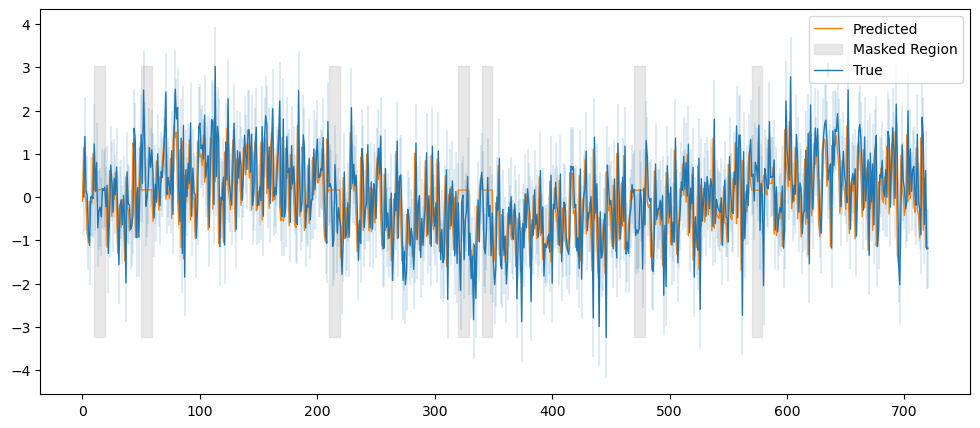

In [62]:
rand_idx = np.random.randint(0, len(star_dataset))
x, t, y, y_err = star_dataset[rand_idx]

# Masking
x_masked, mask = block_predefined_mask_lc(x,
                    block_size=train_config['mask_block_size'],
                    mask_ratio=train_config['mask_ratio'])
with torch.no_grad():
    t_batch = t.unsqueeze(0).squeeze(-1)  # shape [1, 720]
    y_pred, _ = model(x_masked.unsqueeze(0), t_batch)
    y_pred = y_pred.squeeze(0).squeeze(-1)

plt.figure(figsize=(12,5))
plt.errorbar(x=np.linspace(1,720,720),y=y.numpy().squeeze(),yerr=y_err.numpy().squeeze(), label="True",linewidth=1,
             elinewidth=0.2)
plt.plot(y_pred.numpy(), label="Predicted",linewidth=1)
plt.fill_between(np.arange(len(x_masked)), y.min(), y.max(), where=mask, color="lightgrey",
                 alpha=0.5, step="mid",label='Masked Region')
plt.legend()
plt.show()




In [ ]:


# Linear scale reconstruction
axes[0].plot(original, label='Original', alpha=0.7, linewidth=2)
axes[0].plot(reconstructed, label='Reconstructed', alpha=0.7, linewidth=2)
# axes[0].plot(masked, label='Masked Input', alpha=0.7, linewidth=2, linestyle='dashed')
axes[0].fill_between(np.arange(len(masked)), original.min(), original.max(), where=mask[0], color="lightgrey",
                     alpha=0.5, step="mid",label='Masked Region')
axes[0].set_xlabel('Frequency Bin')
axes[0].set_ylabel('Power')
axes[0].set_title('Reconstruction Example (Linear)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)